### Download Cityscapes Dataset

[Cityscapes Data Download Shell Script](https://github.com/cemsaz/city-scapes-script)

```
#!/bin/bash
wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=ankoor&password=<password>&submit=Login' https://www.cityscapes-dataset.com/login/

wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=<i>
```

`i` is value:
- 1: gtFine_trainvaltest.zip (241MB) 
- 2: gtCoarse.zip (1.3GB) 
- 3: leftImg8bit_trainvaltest.zip (11GB) - Contains `<city>_*_leftImg8bit.png` files for `train`, `val`, and `test`
- 4: leftImg8bit_trainextra.zip (44GB) 
- 8: camera_trainvaltest.zip (2MB) 
- 9: camera_trainextra.zip (8MB) 
- 10: vehicle_trainvaltest.zip (2MB) 
- 11: vehicle_trainextra.zip (7MB) 
- 12: leftImg8bit_demoVideo.zip (6.6GB) 
- 28: gtBbox_cityPersons_trainval.zip (2.2MB) 

[PyTorch Cityscapes Dataset Class](https://pytorch.org/docs/master/torchvision/datasets.html#cityscapes)

**Data Directory Structure (after downloading and unzipping)**
```
cityscapes
    ├── gtFine
    │   ├── test
    │   ├── train
    │   └── val
    └── leftImg8bit
        ├── test
        ├── train
        └── val
```

In [1]:
import os
import json
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
class Cityscapes(data.Dataset):
    """
    Modified from: https://pytorch.org/docs/master/_modules/torchvision/datasets/cityscapes.html#Cityscapes
    
    `Cityscapes <http://www.cityscapes-dataset.com/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory ``leftImg8bit``
            and ``gtFine`` or ``gtCoarse`` are located.
        split (string, optional): The image split to use, ``train``, ``test`` or ``val`` if mode="gtFine"
            otherwise ``train``, ``train_extra`` or ``val``
        mode (string, optional): The quality mode to use, ``gtFine`` or ``gtCoarse``
        target_type (string or list, optional): Type of target to use, ``instance``, ``semantic``, ``polygon``
            or ``color``. Can also be a list to output a tuple with all specified target types.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.

    Examples:

        Get semantic segmentation target

        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='train', mode='gtFine',
                                 target_type='semantic')

            img, smnt = dataset[0]

        Get multiple targets

        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='train', mode='gtFine',
                                 target_type=['instance', 'color', 'polygon'])

            img, (inst, col, poly) = dataset[0]

        Validate on the "gtCoarse" set

        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='val', mode='gtCoarse',
                                 target_type='semantic')

            img, smnt = dataset[0]
    """

    def __init__(self, root, split='train', mode='gtFine', target_type='instance',
                 transform=None, target_transform=None):
        self.root = os.path.expanduser(root)
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, mode, split)
        self.transform = transform
        self.target_transform = target_transform
        self.target_type = target_type
        self.split = split
        self.mode = mode
        self.images = []
        self.targets = []
        
        # Modifications to ignore trainId = [255, -1] as per Cityscapes label file and for training with correct index
        self.ignore_index = 255
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.n_classes = len(self.valid_classes)
        self.class_map = dict(zip(self.valid_classes, range(self.n_classes)))

        if mode not in ['gtFine', 'gtCoarse']:
            raise ValueError('Invalid mode! Please use mode="gtFine" or mode="gtCoarse"')

        if mode == 'gtFine' and split not in ['train', 'test', 'val']:
            raise ValueError('Invalid split for mode "gtFine"! Please use split="train", split="test"'
                             ' or split="val"')
        elif mode == 'gtCoarse' and split not in ['train', 'train_extra', 'val']:
            raise ValueError('Invalid split for mode "gtCoarse"! Please use split="train", split="train_extra"'
                             ' or split="val"')

        if not isinstance(target_type, list):
            self.target_type = [target_type]

        if not all(t in ['instance', 'semantic', 'polygon', 'color'] for t in self.target_type):
            raise ValueError('Invalid value for "target_type"! Valid values are: "instance", "semantic", "polygon"'
                             ' or "color"')

        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):
            raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                               ' specified "split" and "mode" are inside the "root" directory')

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                target_types = []
                for t in self.target_type:
                    target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0],
                                                 self._get_target_suffix(self.mode, t))
                    target_types.append(os.path.join(target_dir, target_name))

                self.images.append(os.path.join(img_dir, file_name))
                self.targets.append(target_types)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise target is a json object if target_type="polygon", else the image segmentation.
        """

        image = np.array(Image.open(self.images[index]).convert('RGB'))
        
        # Change channel axis, [W, H, 3] -> [3, W, H] for PyTorch
        image = image.transpose((2, 0, 1)).astype(np.float32)
        
        # Normalize image
        image = image / 255.0
        
        targets = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
                
            # Modifications added to take care of ignore ids and updating ids
            elif t == 'semantic':
                target = np.array(Image.open(self.targets[index][i])).astype(np.int32)
                target = self._encode_target(target)
            else:
                target = np.array(Image.open(self.targets[index][i])).astype(np.int32)

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]
        
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            target = self.target_transform(target)

        return torch.from_numpy(image), torch.from_numpy(target)


    def __len__(self):
        return len(self.images)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Split: {}\n'.format(self.split)
        fmt_str += '    Mode: {}\n'.format(self.mode)
        fmt_str += '    Type: {}\n'.format(self.target_type)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

    def _load_json(self, path):
        with open(path, 'r') as file:
            data = json.load(file)
        return data

    def _get_target_suffix(self, mode, target_type):
        if target_type == 'instance':
            return '{}_instanceIds.png'.format(mode)
        elif target_type == 'semantic':
            return '{}_labelIds.png'.format(mode)
        elif target_type == 'color':
            return '{}_color.png'.format(mode)
        else:
            return '{}_polygons.json'.format(mode)
        
    def _encode_target(self, mask):
        # Fill void class with value 255
        for void_class in self.void_classes:
            mask[mask == void_class] = self.ignore_index
            
        # Fill valid class with updated index
        for valid_class in self.valid_classes:
            mask[mask == valid_class] = self.class_map[valid_class]
            
        return mask

### Dataloader

In [6]:
val_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=True)
for i, (img, lab) in enumerate(val_loader):
    print(img.shape, lab.shape)
    if i == 0:
        break

# Labels
print(list(np.unique(lab.numpy())))

torch.Size([1, 3, 1024, 2048]) torch.Size([1, 1024, 2048])
[0, 1, 4, 5, 7, 8, 9, 10, 13, 14, 15, 255]


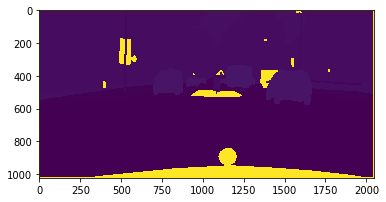

In [7]:
# Check how the label looks like
plt.imshow(lab.squeeze(0).numpy())

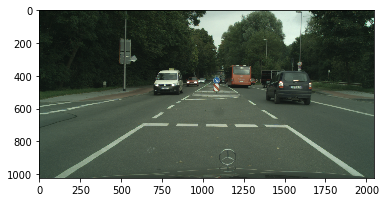

In [8]:
plt.imshow(img.squeeze(0).numpy().transpose(1, 2, 0))

# Cityscape Labels

[Reference](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)

In [9]:
# Cityscapes labels

from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (200, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

### States to update Cityscapes Dataset Class

In [10]:
# Total Classes
total_classes = len(labels)
print('Total number of classes: ', total_classes)

# Ignore labels with Train ID 255
ignore_id = 255
num_ignore = sum([1 for lab in labels if lab.trainId in [ignore_id,  -1]])
print('Number of classes to ignore: ', num_ignore)

# Training classes
n_classes = total_classes - num_ignore
print('Number of training classes: ', n_classes)  # What about trainId = -1?

# Ignore IDs
void_classes = [lab.id for lab in labels if lab.trainId in [ignore_id,  -1]]
print('Void classes: ', void_classes)

# Valid IDs
valid_classes = [lab.id for lab in labels if lab.trainId not in [ignore_id, -1]]
print('Valid classes: ', valid_classes)

# Number of valid classes
n_valid_classes = len(valid_classes)
print('Number of valid classes: ', n_valid_classes)

# Create a class map that maps old label id to new label id
class_map = dict(zip(valid_classes, range(n_valid_classes)))
print('Class map: ', class_map)

Total number of classes:  35
Number of classes to ignore:  16
Number of training classes:  19
Void classes:  [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
Valid classes:  [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
Number of valid classes:  19
Class map:  {32: 17, 33: 18, 7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16}


In [11]:
color_map = {new_id: lab.color for old_id, new_id in class_map.items() for lab in labels if lab.id == old_id}
print('Color map: ', color_map)
print()

name_map = {new_id: lab.name.title() for old_id, new_id in class_map.items() for lab in labels if lab.id == old_id}
print('Name map: ', name_map)

Color map:  {0: (128, 64, 128), 1: (244, 35, 232), 2: (70, 70, 70), 3: (102, 102, 156), 4: (190, 153, 153), 5: (153, 153, 153), 6: (250, 170, 30), 7: (220, 220, 0), 8: (107, 142, 35), 9: (152, 251, 152), 10: (70, 130, 180), 11: (200, 20, 60), 12: (255, 0, 0), 13: (0, 0, 142), 14: (0, 0, 70), 15: (0, 60, 100), 16: (0, 80, 100), 17: (0, 0, 230), 18: (119, 11, 32)}

Name map:  {0: 'Road', 1: 'Sidewalk', 2: 'Building', 3: 'Wall', 4: 'Fence', 5: 'Pole', 6: 'Traffic Light', 7: 'Traffic Sign', 8: 'Vegetation', 9: 'Terrain', 10: 'Sky', 11: 'Person', 12: 'Rider', 13: 'Car', 14: 'Truck', 15: 'Bus', 16: 'Train', 17: 'Motorcycle', 18: 'Bicycle'}


In [12]:
# Just for testing 
old_color_map = {c: lab.color for c in valid_classes for lab in labels if lab.id == c}
print('Old Id Color map: ', old_color_map)

Old Id Color map:  {32: (0, 0, 230), 33: (119, 11, 32), 7: (128, 64, 128), 8: (244, 35, 232), 11: (70, 70, 70), 12: (102, 102, 156), 13: (190, 153, 153), 17: (153, 153, 153), 19: (250, 170, 30), 20: (220, 220, 0), 21: (107, 142, 35), 22: (152, 251, 152), 23: (70, 130, 180), 24: (200, 20, 60), 25: (255, 0, 0), 26: (0, 0, 142), 27: (0, 0, 70), 28: (0, 60, 100), 31: (0, 80, 100)}


# Better Color Map based on [ColorBrewer](http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3)

In [13]:
print('Class names: ', [v for k, v in name_map.items()])

Class names:  ['Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'Traffic Light', 'Traffic Sign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car', 'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle']


In [14]:
class_color_map = {
    'Road': (135, 135, 135),  # Medium Grey
    'Sidewalk': (224, 224, 224),  # Light Grey
    'Building': (255, 237, 160),  # Light Yellow
    'Wall': (245, 222, 179), # Light Green
    'Fence': (247, 252, 185),  # Light Yellow
    'Pole': (190, 153, 153),  # Grey variation
    'Traffic Light': (255, 127, 0),  # Orange Yellow
    'Traffic Sign': (255, 255, 51),  # Yellow
    'Vegetation': (51, 160, 44),  # Green
    'Terrain': (191, 129, 45),  # Medium Brown
    'Sky': (135, 206, 250),  # Light Blue
    'Person': (227, 26, 28),  # Red
    'Rider': (252, 146, 114),  # Cream Red
    'Car': (30, 144, 255),  # Blue
    'Truck': (106, 61, 154),  # Purple
    'Bus': (102, 194, 164),  # Green Blue  188, 128, 189
    'Train': (70, 130, 180), #(0, 68, 27),  # Dark Green
    'Motorcycle': (103, 0, 13),  # Dark Brown
    'Bicycle': (231, 41, 138),  # Pink 
}

In [15]:
class_id_color_map = {i: class_color_map[name] for i, name in name_map.items()}
print(class_id_color_map)

{0: (135, 135, 135), 1: (224, 224, 224), 2: (255, 237, 160), 3: (245, 222, 179), 4: (247, 252, 185), 5: (190, 153, 153), 6: (255, 127, 0), 7: (255, 255, 51), 8: (51, 160, 44), 9: (191, 129, 45), 10: (135, 206, 250), 11: (227, 26, 28), 12: (252, 146, 114), 13: (30, 144, 255), 14: (106, 61, 154), 15: (102, 194, 164), 16: (70, 130, 180), 17: (103, 0, 13), 18: (231, 41, 138)}


# Color Legend for App

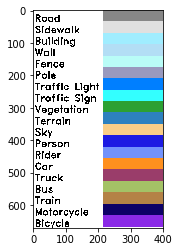

In [16]:
import cv2

# Grey color canvas
const = 35
width = 400 
legend = np.zeros(((n_valid_classes * const) + const//2 - 12, width, 3), dtype=np.uint8) + 255

for i in range(len(color_map)):
    # Get class name and color
    name = name_map[i]
    color = class_color_map[name]
    
    # Place text 
    cv2.putText(legend, name, (5, (i*const)+const), 
                cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 2)
    
    # Place color
    cv2.rectangle(legend, (215, i*const), (400, (i*const)+const), 
                  color[::-1], cv2.FILLED)
    
cv2.imwrite('Cityscapes_Legend.jpg', legend)
plt.imshow(legend)

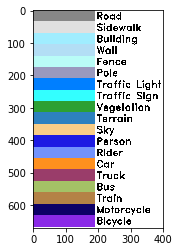

In [17]:
import cv2

# Grey color canvas
const = 35
width = 400 
legend = np.zeros(((n_valid_classes * const) + const//2 - 12, width, 3), dtype=np.uint8) + 255

for i in range(len(color_map)):
    # Get class name and color
    name = name_map[i]
    color = class_color_map[name]
    
    # Place text 
    cv2.putText(legend, name, (195, (i*const)+const-7), 
                cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 2)
    
    # Place color
    cv2.rectangle(legend, (0, i*const), (190, (i*const)+const), 
                  color[::-1], cv2.FILLED)
    
cv2.imwrite('CityscapesLegend.jpg', legend)
plt.imshow(legend)

In [18]:
for i in range(len(color_map)):
    print('(x={}, y={})'.format(5, (i * const) + const))

(x=5, y=35)
(x=5, y=70)
(x=5, y=105)
(x=5, y=140)
(x=5, y=175)
(x=5, y=210)
(x=5, y=245)
(x=5, y=280)
(x=5, y=315)
(x=5, y=350)
(x=5, y=385)
(x=5, y=420)
(x=5, y=455)
(x=5, y=490)
(x=5, y=525)
(x=5, y=560)
(x=5, y=595)
(x=5, y=630)
(x=5, y=665)


In [19]:
400-215

185

### Development

In [20]:
pred = torch.randn([1, 19, 1024, 2048])
cm = torch.argmax(pred.squeeze(0), dim=0)
h, w = cm.shape
print('Class map shape: ', cm.shape)

cm = cm.numpy()

Class map shape:  torch.Size([1024, 2048])


Color img shape:  (1024, 2048, 3)


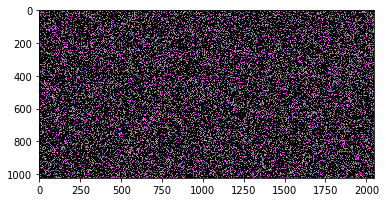

In [21]:
# Create a zero initialized array using list of named tuples
color_img = np.zeros((h, w, 3))
print('Color img shape: ', color_img.shape)

# Populate the zero initialized color img with mapped color
for label in labels:
    if not label.ignoreInEval:
        # Find array locations and populate with mapped color
        color_img[cm == label.id] = np.array(label.color)
color_img = color_img.astype(np.uint8)

plt.imshow(color_img)  # Label Ids mapped to color plotted

Color img shape:  (1024, 2048, 3)


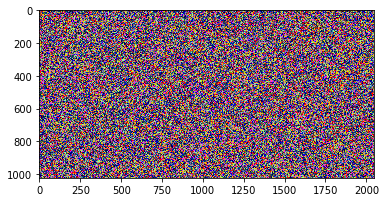

In [22]:
# CORRECT Approach!
# Create a zero initialized array using color map dict
color_img = np.zeros((h, w, 3))
print('Color img shape: ', color_img.shape)

# Populate the zero initialized color img with mapped color
for idx, color in color_map.items():
    color_img[cm == idx] = np.array(color)
    
color_img = color_img.astype(np.uint8)
plt.imshow(color_img)  # Label Ids mapped to color plotted

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


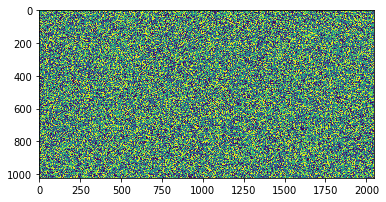

In [23]:
print(np.unique(cm))
plt.imshow(cm)  # Label Ids plotted, note Label Ids are in range 0-19!

### Ignore Index and Update Index

In [24]:
np.random.seed(7)
target = np.random.randint(0, high=9, size=(8, 10))
print(target)

[[4 6 3 3 7 7 7 8 8 7]
 [6 4 0 7 0 7 6 3 5 8]
 [8 7 5 0 0 2 8 6 4 7]
 [3 3 8 3 0 1 0 0 6 7]
 [7 3 0 7 7 7 0 5 4 3]
 [1 3 1 3 4 3 1 5 1 2]
 [3 2 2 5 7 3 0 3 4 5]
 [3 0 4 8 6 7 2 7 3 8]]


In [25]:
# Replace 0 with -1
mask = target == 0
print(mask.astype(np.int32))

target[mask] = -1
print(target)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 0]
 [0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
[[ 4  6  3  3  7  7  7  8  8  7]
 [ 6  4 -1  7 -1  7  6  3  5  8]
 [ 8  7  5 -1 -1  2  8  6  4  7]
 [ 3  3  8  3 -1  1 -1 -1  6  7]
 [ 7  3 -1  7  7  7 -1  5  4  3]
 [ 1  3  1  3  4  3  1  5  1  2]
 [ 3  2  2  5  7  3 -1  3  4  5]
 [ 3 -1  4  8  6  7  2  7  3  8]]


In [26]:
def encode_target(mask):
    void_classes = [1, 3, 5, 7, 9]
    valid_classes = [2, 4, 6, 8]
    ignore_index = 0
    for void_class in void_classes:
        mask[mask == void_class] = ignore_index
        
    for valid_class in valid_classes:
        mask[mask == valid_class] = -1
    return mask

In [27]:
np.random.seed(7)
target = np.random.randint(0, high=9, size=(8, 10))
print(target)

[[4 6 3 3 7 7 7 8 8 7]
 [6 4 0 7 0 7 6 3 5 8]
 [8 7 5 0 0 2 8 6 4 7]
 [3 3 8 3 0 1 0 0 6 7]
 [7 3 0 7 7 7 0 5 4 3]
 [1 3 1 3 4 3 1 5 1 2]
 [3 2 2 5 7 3 0 3 4 5]
 [3 0 4 8 6 7 2 7 3 8]]


In [28]:
e_target = encode_target(target)
print(e_target)

[[-1 -1  0  0  0  0  0 -1 -1  0]
 [-1 -1  0  0  0  0 -1  0  0 -1]
 [-1  0  0  0  0 -1 -1 -1 -1  0]
 [ 0  0 -1  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0 -1  0  0  0  0 -1]
 [ 0 -1 -1  0  0  0  0  0 -1  0]
 [ 0  0 -1 -1 -1  0 -1  0  0 -1]]


In [29]:
valid_classes = [2, 4, 6, 8]
n_classes = len(valid_classes)
class_map = zip(valid_classes, range(n_classes))
class_map = {k:v for k, v in class_map}
class_map

{2: 0, 4: 1, 6: 2, 8: 3}

# Check Images and Labels

In [30]:
path = './cityscapes/leftImg8bit/train/'
cities = os.listdir(path)
print(cities)

['cologne', 'bremen', 'bochum', 'stuttgart', 'strasbourg', 'krefeld', 'tubingen', 'hamburg', 'zurich', 'weimar', 'monchengladbach', 'ulm', 'jena', 'dusseldorf', 'darmstadt', 'hanover', 'erfurt', 'aachen']


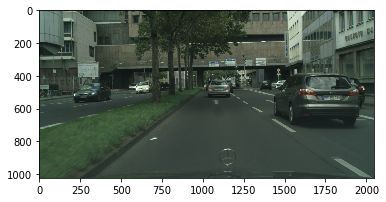

In [31]:
# Image
img_path = './cityscapes/leftImg8bit/train/cologne/cologne_000115_000019_leftImg8bit.png'
img = Image.open(img_path)

plt.imshow(img)

[0, 1, 3, 4, 6, 7, 8, 11, 17, 19, 20, 21, 22, 26, 33]


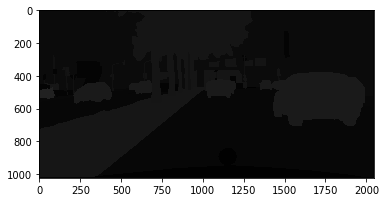

In [32]:
# Label Ids (for segmentation)
lab_path = './cityscapes/gtFine/train/cologne/cologne_000115_000019_gtFine_labelIds.png'
lab = Image.open(lab_path)

# Labels
print(list(np.unique(lab)))

plt.imshow(lab)

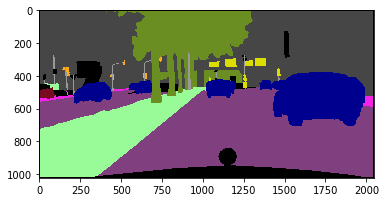

In [33]:
# Old approach
lab = np.array(lab)
h, w = lab.shape

color_img = np.zeros((h, w, 3))

for label in labels:
    if not label.ignoreInEval:
        # Find array locations and populate with mapped color
        color_img[lab == label.id] = np.array(label.color)
color_img = color_img.astype(np.uint8)

plt.imshow(color_img)  # Label Ids mapped to color plotted

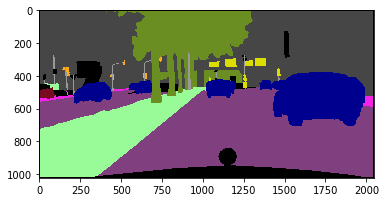

In [34]:
# Old approach
lab = np.array(lab)
h, w = lab.shape

color_img = np.zeros((h, w, 3))

for idx, color in old_color_map.items():
    color_img[lab == idx] = np.array(color)
    
color_img = color_img.astype(np.uint8)

plt.imshow(color_img)  # Label Ids mapped to color plotted

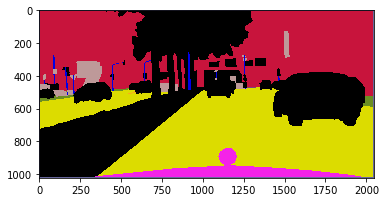

In [35]:
# Test new approach (Note colors are wrong here because label index is old but color index is new)
lab = np.array(lab)
h, w = lab.shape

color_img = np.zeros((h, w, 3))

for idx, color in color_map.items():
    color_img[lab == idx] = np.array(color)
    
color_img = color_img.astype(np.uint8)

plt.imshow(color_img)  # Label Ids mapped to color plotted

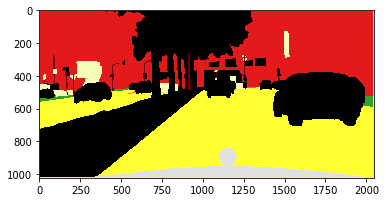

In [36]:
# Test new approach (Note colors are wrong here because label index is old but color index is new)
lab = np.array(lab)
h, w = lab.shape

color_img = np.zeros((h, w, 3))

for idx, color in class_id_color_map.items():
    color_img[lab == idx] = np.array(color)
    
color_img = color_img.astype(np.uint8)

plt.imshow(color_img)  # Label Ids mapped to color plotted

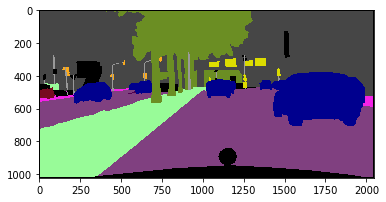

In [37]:
# Color
clr_path = './cityscapes/gtFine/train/cologne/cologne_000115_000019_gtFine_color.png'
clr = Image.open(clr_path)

plt.imshow(clr)

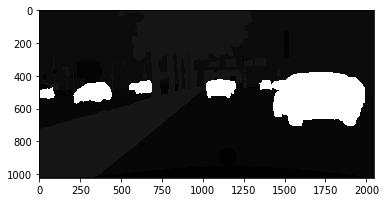

In [38]:
# Instance Ids (instance segmentation?)
inst_path = './cityscapes/gtFine/train/cologne/cologne_000115_000019_gtFine_instanceIds.png'
inst = Image.open(inst_path)

plt.imshow(inst)

In [39]:
# Polygons
poly_path = './cityscapes/gtFine/train/cologne/cologne_000115_000019_gtFine_polygons.json'

with open(poly_path, 'r') as j:
    poly = json.load(j)
    
print(poly)

{'objects': [{'polygon': [[1036, 476], [924, 483], [740, 484], [550, 488], [469, 489], [202, 519], [-2, 545], [-1, 1], [2044, 2], [2044, 551], [1570, 485], [1432, 463], [1289, 470], [1183, 472]], 'label': 'building'}, {'polygon': [[1215, 352], [1224, 371], [1228, 384], [1236, 390], [1242, 395], [1240, 408], [1239, 412], [1241, 419], [1242, 429], [1244, 443], [1237, 452], [1183, 463], [1106, 470], [989, 477], [946, 476], [913, 476], [904, 456], [901, 450], [893, 434], [892, 425], [894, 414], [893, 405], [896, 394], [896, 387], [896, 376], [908, 353], [1163, 349]], 'label': 'vegetation'}, {'polygon': [[782, 419], [761, 422], [758, 423], [746, 426], [728, 426], [722, 405], [722, 388], [721, 376], [728, 371], [762, 371], [788, 371], [789, 373], [791, 387], [789, 394], [786, 401]], 'label': 'vegetation'}, {'polygon': [[1046, 433], [1052, 419], [1047, 416], [1044, 412], [1040, 411], [1039, 417], [1037, 424]], 'label': 'traffic sign'}, {'polygon': [[1203, 403], [1170, 403], [1171, 447], [1191